## Etapas

### Parte 1
- **Tamanho do dataset e Distribuição de classes**
- **Realizando alguns checks de sanidade**
    - Verificação de arquivos corrompidos
    - Verificação de tipagem dos arquivos
    - Verificação de canais das imagens
- **Visualizando nosso dataset**
- **Visualizando a distribuição de pixels dos canais por classe**

### Parte 2
- **Identificação de imagens muito escuras e muito claras e remove-las**
- **Identificando duplicatas nos nossos dados**
- **Transformando nossas imagens em uma Feature Matrix**
- **Usar KMeans para clusterizar nossas imagens**
- **Report final**

In [2]:
import math
import os
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.image as imread
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image

## Config

In [3]:
TRAIN_PATH = Path("data", "raw", "train")
TEST_PATH = Path("data", "raw", "test")
LABELS_TRAIN_PATH = Path("data", "raw", "train_labels.csv")

## Tamanho do dataset e Distribuição de Classes

In [4]:
files_train_gen = TRAIN_PATH.glob("*.*")
files_train_path_list = [file for file in files_train_gen]

files_test_gen = TEST_PATH.glob("*.*")
files_test_path_list = [file for file in files_test_gen]

print("Training size: {}".format(len(files_train_path_list)))
print("Test size: {}".format(len(files_test_path_list)))

Training size: 220025
Test size: 57458


In [5]:
label_train_df = pd.read_csv(LABELS_TRAIN_PATH)
label_train_df.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

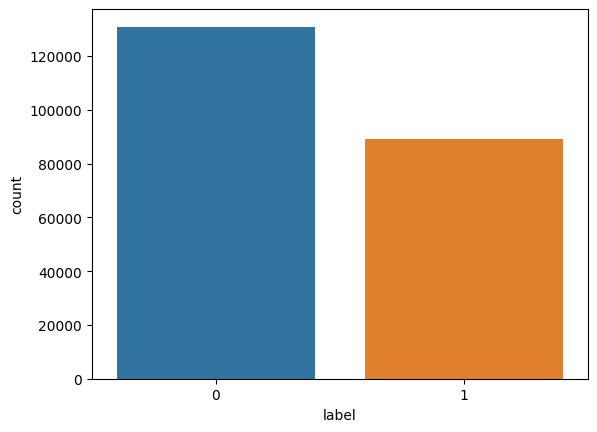

In [6]:
_ = sns.countplot(data=label_train_df, x="label")
plt.show()

In [7]:
label_train_df.value_counts(["label"], normalize=True)

label
0        0.594969
1        0.405031
dtype: float64

## Checks de sanidade

In [18]:
class SanityChecks:
    def __init__(self, path: Path) -> None:
        self.path = path
        self.files_list = self.__get_path_list()
        self.mode_types = []
        self.width = []
        self.height = []

    def __get_path_list(self) -> list:
        files_path_gen = self.path.glob("*.*")
        return [file for file in files_path_gen]

    def check_corruption(self) -> dict:
        error = []
        for file in self.files_list:
            try:
                img = Image.open(file)
                self.mode_types.append(img.mode)
                self.width.append(img.width)
                self.height.append(img.height)
            except:
                error.append(file)
        return {"qt_errors": len(error), "files_erros": error}
    
    def check_typing(self) -> dict:
        print(self.files_list[0])
        ext = [str(file).split(".")[-1] for file in self.files_list]
        return {
            "ext": list(set(ext))
        }
    
    def check_mode(self) -> dict:
        return {
            "modes": list(set(self.mode_types))
        }
    
    def check_dimensions(self) -> dict:
        return {
            "width": list(set(self.width)),
            "height": list(set(self.height))
        }


In [20]:
sanity_checks = SanityChecks(TRAIN_PATH)
print(sanity_checks.check_corruption())
print(sanity_checks.check_typing())
print(sanity_checks.check_mode())
print(sanity_checks.check_dimensions())

{'qt_errors': 0, 'files_erros': []}
data/raw/train/ff36ca3fcc306412eddf0543279305c0fdf2c73c.tif
{'ext': ['tif']}
{'modes': ['RGB']}
{'width': [96], 'height': [96]}


In [21]:
sanity_checks = SanityChecks(TEST_PATH)
print(sanity_checks.check_corruption())
print(sanity_checks.check_typing())
print(sanity_checks.check_mode())
print(sanity_checks.check_dimensions())

{'qt_errors': 0, 'files_erros': []}
data/raw/test/7073833f7ef20abd784565b87f5281e1fa934d4c.tif
{'ext': ['tif']}
{'modes': ['RGB']}
{'width': [96], 'height': [96]}


In [27]:
def plot_images(path: Path, sample_size: int):
    files_path_gen = path.glob("*.*")
    files = [file for file in files_path_gen]

    sample = np.random.choice(files, sample_size)

    # adapting rows and columns
    cols = math.ceil(math.sqrt(sample_size))
    rows = math.ceil(math.sqrt(sample_size))

    plt.figure(figsize=(10, 10))
    plt.suptitle("Imagens aleatórias da nossa base de dados")
    for i, file in enumerate(sample):
        img = Image.open(file)
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    



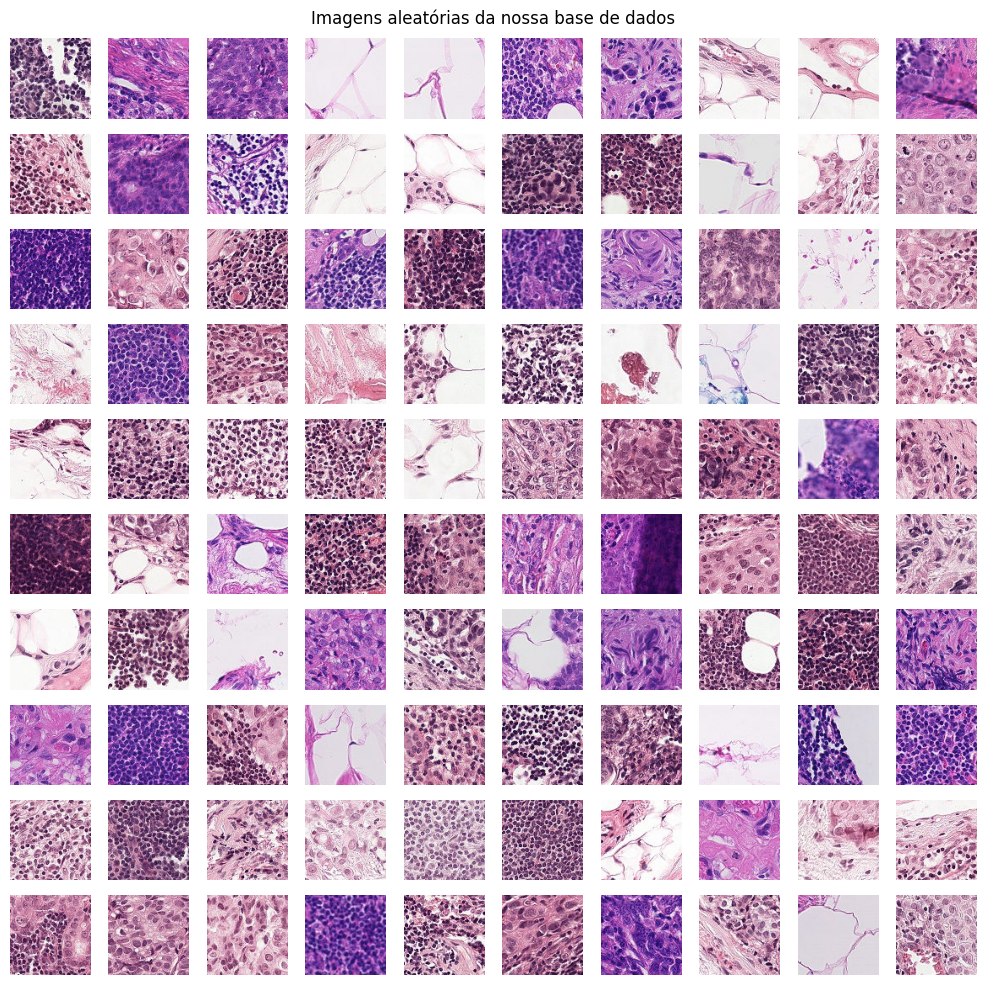

In [29]:
plot_images(TRAIN_PATH, sample_size=100)

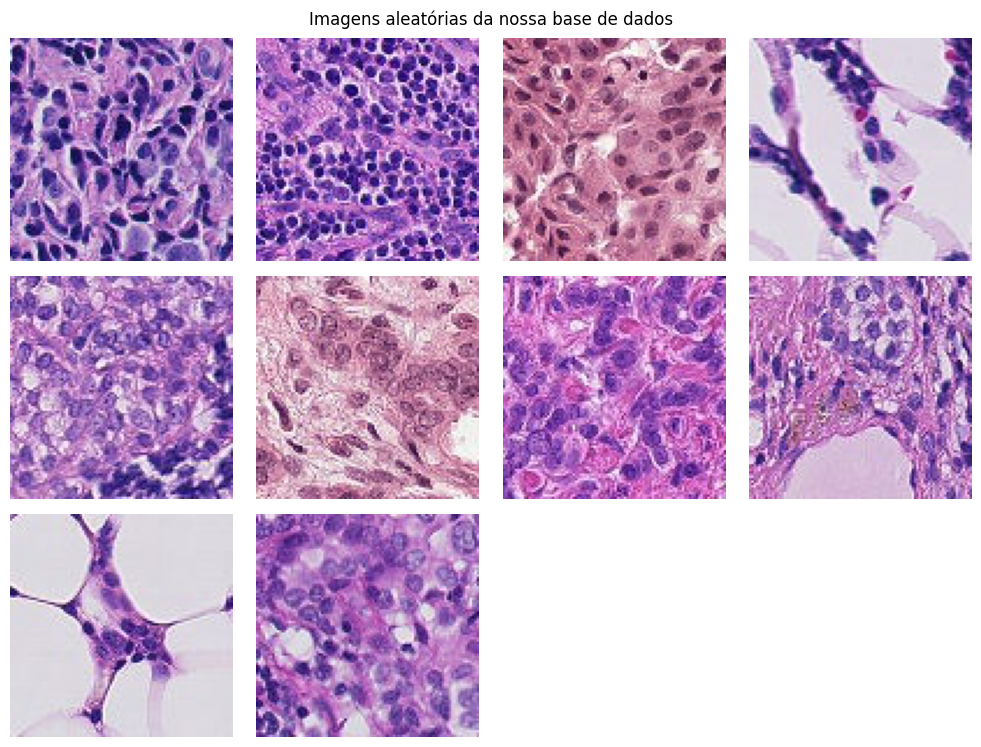

In [30]:
plot_images(TEST_PATH, sample_size=10)

## Visualizando a distribuição de pixels

In [42]:
class PixelsVerify:
    def __init__(self, path: Path, labels_path: Path) -> None:
        self.train_path = path
        self.files = self.__get_path_list()
        self.labels_train_df = pd.read_csv(labels_path)
        self.sample = []
        self.rows = None
        self.cols = None

    def __get_path_list(self) -> list:
        files_path_gen = self.train_path.glob("*.*")
        return [file for file in files_path_gen]

    def __get_rbg_pixels(self, image):
        pixels = image.histogram()
        pixels_r = pixels[:256]
        pixels_g = pixels[256:512]
        pixels_b = pixels[512:]
        return {"r": pixels_r, "g": pixels_g, "b": pixels_b}

    def plot_histograms(self, sample_size):
        self.sample = np.random.choice(self.files, sample_size)

        # extract those labels
        name_ids = [
            str(sample_path).split("/")[-1].split(".")[0] for sample_path in self.sample
        ]

        labels = self.labels_train_df[self.labels_train_df["id"].isin(name_ids)][
            "label"
        ].tolist()

        # adapting rows and columns
        self.cols = math.ceil(math.sqrt(sample_size))
        self.rows = math.ceil(math.sqrt(sample_size))

        plt.figure(figsize=(10, 10))
        plt.suptitle("Histogramas aleatórias da nossa base de dados")
        for i, file in enumerate(self.sample):
            img = Image.open(file)
            pixels = self.__get_rbg_pixels(img)
            plt.subplot(self.rows, self.cols, i + 1)
            plt.plot(list(range(0, 256)), pixels["r"], color="red")
            plt.plot(list(range(0, 256)), pixels["g"], color="green")
            plt.plot(list(range(0, 256)), pixels["b"], color="blue")
            plt.title("{} - {}".format(i, labels[i]))

        plt.tight_layout()
        plt.show()

    def plot_imgs_from_histograms(self):
        plt.figure(figsize=(10, 10))
        plt.suptitle("Imagens aleatórias referente aos Histogramas")
        for i, file in enumerate(self.sample):
            img = Image.open(file)
            plt.subplot(self.rows, self.cols, i+1)
            plt.imshow(img)
            plt.title(f"{i}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()


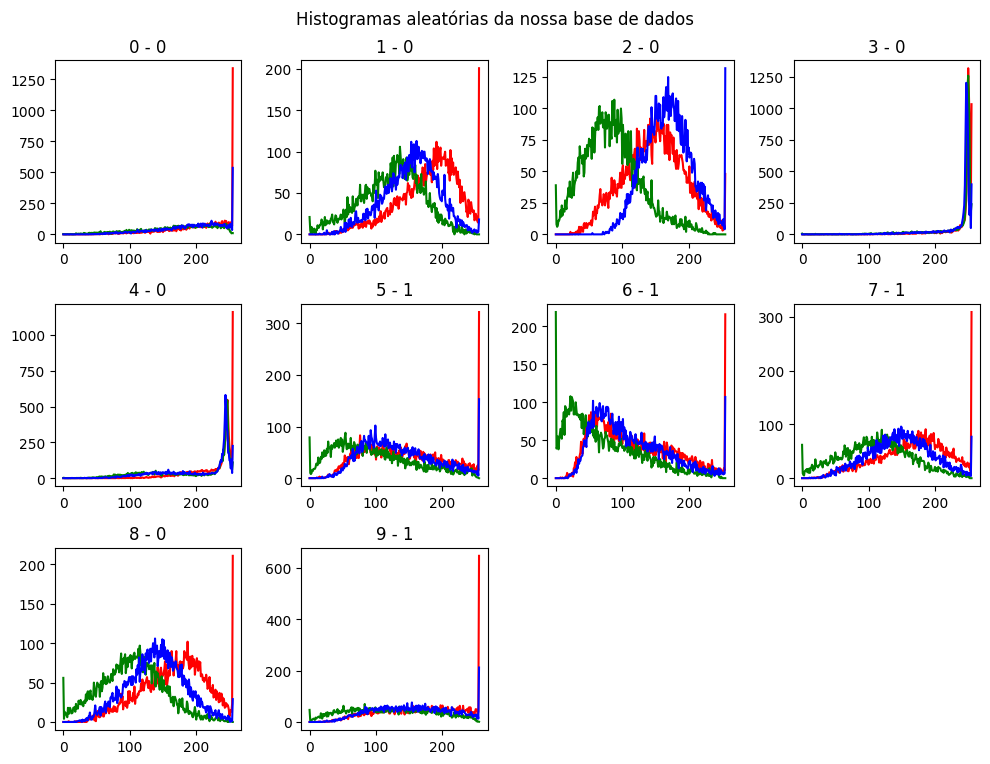

In [43]:
pixels = PixelsVerify(TRAIN_PATH, LABELS_TRAIN_PATH)
pixels.plot_histograms(sample_size=10)

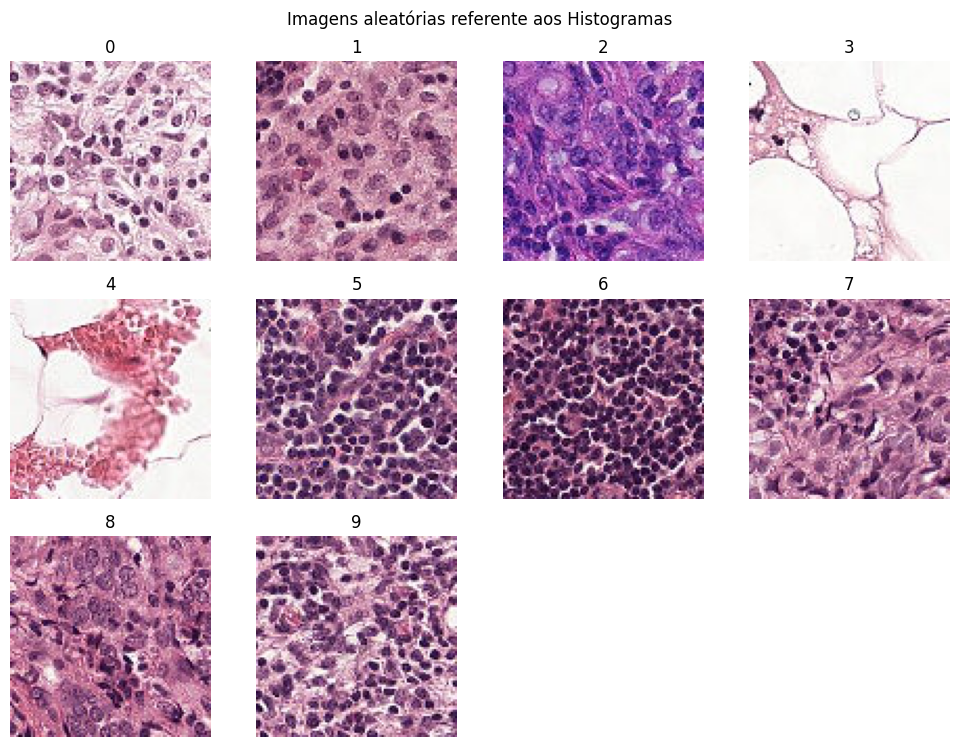

In [44]:
pixels.plot_imgs_from_histograms()